###Load data

In [ ]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.1 MB/s eta 0:00:00


In [ ]:
import os
from os import listdir
from os.path import isfile, join
import numpy as np
from tqdm import tqdm

import torch
from torch.autograd import Function
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence

import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid

from tensorboardX import SummaryWriter

In [ ]:
FOLDER_PATH = "/Path/to/your/dataset/"
os.chdir(FOLDER_PATH)

Case_Int_num_list=[]
MS_type = []

FOLDER_LIST = ["Case1_Dream3D", "Case2_Ellipse", "Case3_Laminated", "Case4_Rectangle", "Case5_RectangleExchangeMF"]
#FOLDER_LIST = ["Case1_Dream3D", "Case2_Ellipse", "Case4_Rectangle", "Case5_RectangleExchangeMF"]

for folder in FOLDER_LIST:
  path = join(FOLDER_PATH, folder)
  filename_list_all=[f for f in listdir(path) if isfile(join(path, f))]

  for i in filename_list_all:
    if '_Microstructure.txt' in i:
      Case_Int_index=i.split('_')
      Case_Int_num_list.append(Case_Int_index[0] + '_' + Case_Int_index[1])
      MS_type.append(folder)

image = []
Dstrain_sample = []
Dstrain_element = []
M_fraction = []
UTS = []
Void_Dist = []
dir_name = []

for i, j in enumerate(tqdm(Case_Int_num_list)):
    os.chdir(join(FOLDER_PATH, MS_type[i]))
    M_filename = j + '_Microstructure.txt'

    M_1 = np.genfromtxt(M_filename, delimiter=',')
    M_2 = M_1[:,0]
    M_2 = np.where(M_2==2, 0, M_2)
    M_2 = np.where(M_2==1, 255, M_2)

    frac_tmp = np.count_nonzero(M_2==0)/(128*128)
    M_2 = np.reshape(M_2, (128, 128))

    Dstrain_filename = j + '_DamageStrain.txt'
    Dstrain_1=np.genfromtxt(Dstrain_filename,skip_header=1)

    UTS_filename = j + '_UTS.txt'
    UTS_1=np.genfromtxt(UTS_filename,skip_header=1)

    image.append(M_2)
    image.append(np.flipud(M_2).copy())
    image.append(np.fliplr(M_2).copy())

    for i in range(3):
      M_fraction.append(frac_tmp)
      Dstrain_sample.append(Dstrain_1[0])
      Dstrain_element.append(Dstrain_1[1])
      UTS.append(UTS_1[0])
      dir_name.append(j)

print('the number of image is: ', len(image))

In [ ]:
def regularization(y, max, min):
  y[0, :] = (y[0, :] - min) / (max - min)
  return y

In [ ]:
from PIL import Image
import random
import math

n_test = 100 * -1

image = np.asarray(image)
Void_Dist= np.asarray(Void_Dist)

print('image.shape is: ', image.shape)


y1 = np.asarray(Dstrain_sample).reshape(1, len(Dstrain_sample))
y2= np.asarray(UTS).reshape(1, len(UTS))

UTS_max = np.max(y2.reshape(-1))
UTS_min = np.min(y2.reshape(-1))
print("UTS max: {0:.1f}, UTS min: {1:.1f}".format(UTS_max, UTS_min))
y2 = regularization(y2, UTS_max, UTS_min)

y = np.concatenate([y1, y2], 0).transpose(1,0)

print('Y.shape is: ', y.shape)

arr = np.arange(image.shape[0])

####-----------USE test.txt-------------####
#   This is used to fix the test images.   #
f = open('test.txt', 'r')
datalist = f.readlines()
ind_list = []

for test_case in datalist:
  test_case = test_case[:-1]
  ind = [i for i, x in enumerate(dir_name) if x == test_case]
  #ind = dir_name.index(test_case)
  if ind != []:
    ind_list.append(ind)

ind_list = np.array(ind_list).reshape(-1)

n_test = len(ind_list) * -1
elements_to_move = arr[ind_list]
arr = np.delete(arr, ind_list)
arr = np.append(arr, elements_to_move)

####------------------------------------####

# random.shuffle(arr)

(tx_train), (tx_test) = image[arr[:n_test]], image[arr[n_test:]] # the number of test images have to be larger than batch_size
(ty_train), (ty_test) = y[arr[:n_test]], y[arr[n_test:]]

tx_train = tx_train.astype('float32') / 255.
tx_train = np.reshape(tx_train, (len(tx_train), 128, 128, 1))
ty_train = ty_train.astype('float32')
ty_train = np.reshape(ty_train, (len(ty_train), y.shape[1]))
print('tx_train.shape is: ', tx_train.shape)
print('ty_train.shape is: ', ty_train.shape)

tx_test = tx_test.astype('float32') / 255.
tx_test = np.reshape(tx_test, (len(tx_test), 128, 128, 1))
ty_test = ty_test.astype('float32')
ty_test = np.reshape(ty_test, (len(ty_test), y.shape[1]))
print('tx_test.shape is: ', tx_test.shape)
print('ty_test.shape is: ', ty_test.shape)

tx_train = np.transpose(tx_train, (0,3,1,2))
print('tx_train.shape is: ', tx_train.shape)
tx_test = np.transpose(tx_test, (0,3,1,2))
print('tx_test.shape is: ', tx_test.shape)

image.shape is:  (15231, 128, 128)
UTS max: 1508.2, UTS min: 446.0
Y.shape is:  (15231, 2)
tx_train.shape is:  (14931, 128, 128, 1)
ty_train.shape is:  (14931, 2)
tx_test.shape is:  (300, 128, 128, 1)
ty_test.shape is:  (300, 2)
tx_train.shape is:  (14931, 1, 128, 128)
tx_test.shape is:  (300, 1, 128, 128)


In [ ]:
tx_train = torch.tensor(tx_train)
ty_train = torch.tensor(ty_train)
tx_test = torch.tensor(tx_test)
ty_test = torch.tensor(ty_test)

In [ ]:
from torch.utils.data import  Dataset, TensorDataset

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transform:
            x = self.transform(x)
        y = self.tensors[1][index]
        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [ ]:
transform = transforms.Compose([
            transforms.Normalize((0.5,), (0.5,)), # for gray
        ])

train_dataset = CustomTensorDataset(tensors=(tx_train, ty_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(tx_test, ty_test), transform=transform)
valid_dataset = test_dataset

###Define module for VQVAE

In [ ]:
class VectorQuantization(Function):
    @staticmethod
    def forward(ctx, inputs, codebook):
        with torch.no_grad():
            embedding_size = codebook.size(1)
            inputs_size = inputs.size()
            inputs_flatten = inputs.view(-1, embedding_size)

            codebook_sqr = torch.sum(codebook ** 2, dim=1)
            inputs_sqr = torch.sum(inputs_flatten ** 2, dim=1, keepdim=True)

            # Compute the distances to the codebook
            distances = torch.addmm(codebook_sqr + inputs_sqr,
                inputs_flatten, codebook.t(), alpha=-2.0, beta=1.0)

            _, indices_flatten = torch.min(distances, dim=1)
            indices = indices_flatten.view(*inputs_size[:-1])
            ctx.mark_non_differentiable(indices)

            return indices

    @staticmethod
    def backward(ctx, grad_output):
        raise RuntimeError('Trying to call `.grad()` on graph containing '
            '`VectorQuantization`. The function `VectorQuantization` '
            'is not differentiable. Use `VectorQuantizationStraightThrough` '
            'if you want a straight-through estimator of the gradient.')

class VectorQuantizationStraightThrough(Function):
    @staticmethod
    def forward(ctx, inputs, codebook):
        indices = vq(inputs, codebook)
        indices_flatten = indices.view(-1)
        ctx.save_for_backward(indices_flatten, codebook)
        ctx.mark_non_differentiable(indices_flatten)

        codes_flatten = torch.index_select(codebook, dim=0,
            index=indices_flatten)
        codes = codes_flatten.view_as(inputs)

        return (codes, indices_flatten)

    @staticmethod
    def backward(ctx, grad_output, grad_indices):
        grad_inputs, grad_codebook = None, None

        if ctx.needs_input_grad[0]:
            # Straight-through estimator
            grad_inputs = grad_output.clone()
        if ctx.needs_input_grad[1]:
            # Gradient wrt. the codebook
            indices, codebook = ctx.saved_tensors
            embedding_size = codebook.size(1)

            grad_output_flatten = (grad_output.contiguous()
                                              .view(-1, embedding_size))
            grad_codebook = torch.zeros_like(codebook)
            grad_codebook.index_add_(0, indices, grad_output_flatten)

        return (grad_inputs, grad_codebook)

vq = VectorQuantization.apply
vq_st = VectorQuantizationStraightThrough.apply
__all__ = [vq, vq_st]

In [ ]:
def to_scalar(arr):
    if type(arr) == list:
        return [x.item() for x in arr]
    else:
        return arr.item()


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)

class VQEmbedding(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.embedding = nn.Embedding(K, D)
        self.embedding.weight.data.uniform_(-1./K, 1./K)

    def forward(self, z_e_x):
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        latents = vq(z_e_x_, self.embedding.weight)
        return latents

    def straight_through(self, z_e_x):
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        z_q_x_, indices = vq_st(z_e_x_, self.embedding.weight.detach())
        z_q_x = z_q_x_.permute(0, 3, 1, 2).contiguous()

        z_q_x_bar_flatten = torch.index_select(self.embedding.weight,
            dim=0, index=indices)
        z_q_x_bar_ = z_q_x_bar_flatten.view_as(z_e_x_)
        z_q_x_bar = z_q_x_bar_.permute(0, 3, 1, 2).contiguous()

        return z_q_x, z_q_x_bar


class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(dim, dim//4, 3, 1, 1),
            nn.BatchNorm2d(dim//4),
            nn.ReLU(True),
            nn.Conv2d(dim//4, dim, 1),
            nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)


class VectorQuantizedVAE(nn.Module):
    def __init__(self, input_dim, dim, K=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, dim//4, 4, 2, 1),
            nn.BatchNorm2d(dim//4),
            nn.ReLU(True),
            nn.Conv2d(dim//4, dim//2, 4, 2, 1),
            nn.BatchNorm2d(dim//2),
            nn.ReLU(True),
            nn.Conv2d(dim//2, dim, 4, 2, 1),
            ResBlock(dim),
            ResBlock(dim),
        )

        self.codebook = VQEmbedding(K, dim)

        self.decoder = nn.Sequential(
            ResBlock(dim),
            ResBlock(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, dim//2, 4, 2, 1),
            nn.BatchNorm2d(dim//2),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim//2, dim//4, 4, 2, 1),
            nn.BatchNorm2d(dim//4),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim//4, input_dim, 4, 2, 1),
            nn.Tanh()
        )

        self.apply(weights_init)

    def encode(self, x):
        z_e_x = self.encoder(x)
        latents = self.codebook(z_e_x)
        return latents

    def decode(self, latents):
        z_q_x = self.codebook.embedding(latents).permute(0, 3, 1, 2)  # (B, D, H, W)
        x_tilde = self.decoder(z_q_x)
        return x_tilde

    def forward(self, x):
        z_e_x = self.encoder(x)
        z_q_x_st, z_q_x = self.codebook.straight_through(z_e_x)
        x_tilde = self.decoder(z_q_x_st)
        return x_tilde, z_e_x, z_q_x

In [ ]:
def train(data_loader, model, optimizer, args, writer):
    for images, _ in data_loader:
        images = images.to(args.device)

        optimizer.zero_grad()
        x_tilde, z_e_x, z_q_x = model(images)

        # Reconstruction loss
        loss_recons = F.mse_loss(x_tilde, images)
        # Vector quantization objective
        loss_vq = F.mse_loss(z_q_x, z_e_x.detach())
        # Commitment objective
        loss_commit = F.mse_loss(z_e_x, z_q_x.detach())

        loss = loss_recons + loss_vq + args.beta * loss_commit
        loss.backward()

        # Logs
        writer.add_scalar('loss/train/reconstruction', loss_recons.item(), args.steps)
        writer.add_scalar('loss/train/quantization', loss_vq.item(), args.steps)

        optimizer.step()
        args.steps += 1

def test(data_loader, model, args, writer):
    with torch.no_grad():
        loss_recons, loss_vq = 0., 0.
        for images, _ in data_loader:
            images = images.to(args.device)
            x_tilde, z_e_x, z_q_x = model(images)
            loss_recons += F.mse_loss(x_tilde, images)
            loss_vq += F.mse_loss(z_q_x, z_e_x)

        loss_recons /= len(data_loader)
        loss_vq /= len(data_loader)

    # Logs
    writer.add_scalar('loss/test/reconstruction', loss_recons.item(), args.steps)
    writer.add_scalar('loss/test/quantization', loss_vq.item(), args.steps)

    return loss_recons.item(), loss_vq.item()

def generate_samples(images, model, args):
    with torch.no_grad():
        images = images.to(args.device)
        x_tilde, _, _ = model(images)
    return x_tilde

###VQVAE training

In [ ]:
def main_vqvae(args, Restart = False):
    writer = SummaryWriter('./logs/{0}'.format(args.output_folder))
    save_filename = './models/{0}'.format(args.output_folder)

    # Define the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.num_workers, pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
        batch_size=args.batch_size, shuffle=False, drop_last=True,
        num_workers=args.num_workers, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset,
        batch_size=16, shuffle=True)

    num_channels = 1

    # Fixed images for Tensorboard
    fixed_images, _ = next(iter(test_loader))
    fixed_grid = make_grid(fixed_images, nrow=8, normalize=True)
    writer.add_image('original', fixed_grid, 0)

    model = VectorQuantizedVAE(num_channels, args.hidden_size, args.k).to(args.device)
    summary(model, (1,128,128))

    if Restart:
        FILE_PATH = 'best.pt'
        with open(FILE_PATH, 'rb') as f:
            state_dict = torch.load(f)
            model.load_state_dict(state_dict)

    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    # Generate the samples first once
    reconstruction = generate_samples(fixed_images, model, args)
    grid = make_grid(reconstruction.cpu(), nrow=8, normalize=True)
    writer.add_image('reconstruction', grid, 0)

    best_loss = -1.
    for epoch in range(args.num_epochs):
        train(train_loader, model, optimizer, args, writer)
        loss, _ = test(valid_loader, model, args, writer)
        print("Epoch is " + str(epoch) + "   Loss is " + str(loss))

        reconstruction = generate_samples(fixed_images, model, args)
        grid = make_grid(reconstruction.cpu(), nrow=8, normalize=True)
        writer.add_image('reconstruction', grid, epoch + 1)

        if (epoch == 0) or (loss < best_loss):
            best_loss = loss
            with open('{0}/best.pt'.format(save_filename), 'wb') as f:
                torch.save(model.state_dict(), f)
        with open('{0}/model_{1}.pt'.format(save_filename, epoch + 1), 'wb') as f:
            torch.save(model.state_dict(), f)

In [ ]:
# For VQVAE
import argparse
import os
import multiprocessing as mp

class args():
    def __init__(self):
        self.data_folder =  "./"
        self.hidden_size = 128
        self.k = 16 # 512
        self.batch_size = 64
        self.num_epochs = 300
        self.lr = 2e-6 #2e-4
        self.beta = 1.0
        self.output_folder = 'vqvae'
        self.num_workers = 0
        self.device = 'cuda'
args = args()

# Create logs and models folder if they don't exist
if not os.path.exists('./logs'):
     os.makedirs('./logs')
if not os.path.exists('./models'):
    os.makedirs('./models')
# Device
args.device = torch.device(args.device
    if torch.cuda.is_available() else 'cpu')
# Slurm
if 'SLURM_JOB_ID' in os.environ:
    args.output_folder += '-{0}'.format(os.environ['SLURM_JOB_ID'])
if not os.path.exists('./models/{0}'.format(args.output_folder)):
    os.makedirs('./models/{0}'.format(args.output_folder))
args.steps = 0

main_vqvae(args)
#main_vqvae(args, Restart = True) # For restarting training of VQVAE

### Define module for PixelCNN

In [ ]:
class GatedActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x, y = x.chunk(2, dim=1)
        return F.tanh(x) * F.sigmoid(y)


class GatedMaskedConv2d(nn.Module):
    def __init__(self, mask_type, dim, kernel, residual=True, n_classes=1):
        super().__init__()
        assert kernel % 2 == 1, print("Kernel size must be odd")
        self.mask_type = mask_type
        self.residual = residual
        self.dim = dim

        self.class_cond_embedding = nn.Linear(in_features=n_classes, out_features=2 * dim)


        kernel_shp = (kernel // 2 + 1, kernel)  # (ceil(n/2), n)
        padding_shp = (kernel // 2, kernel // 2)
        self.vert_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.vert_to_horiz = nn.Conv2d(2 * dim, 2 * dim, 1)

        kernel_shp = (1, kernel // 2 + 1)
        padding_shp = (0, kernel // 2)
        self.horiz_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.horiz_resid = nn.Conv2d(dim, dim, 1)

        self.gate = GatedActivation()

    def make_causal(self):
        self.vert_stack.weight.data[:, :, -1].zero_()  # Mask final row
        self.horiz_stack.weight.data[:, :, :, -1].zero_()  # Mask final column

    def forward(self, x_v, x_h, h):
        if self.mask_type == 'A':
            self.make_causal()

        h = self.class_cond_embedding(h)
        h_vert = self.vert_stack(x_v)
        h_vert = h_vert[:, :, :x_v.size(-1), :]
        out_v = self.gate(h_vert + h[:, :, None, None])

        h_horiz = self.horiz_stack(x_h)
        h_horiz = h_horiz[:, :, :, :x_h.size(-2)]
        v2h = self.vert_to_horiz(h_vert)

        out = self.gate(v2h + h_horiz + h[:, :, None, None])
        if self.residual:
            out_h = self.horiz_resid(out) + x_h
        else:
            out_h = self.horiz_resid(out)

        return out_v, out_h


class GatedPixelCNN(nn.Module):
    def __init__(self, input_dim=256, dim=64, n_layers=15, n_classes=1):
        super().__init__()
        self.dim = dim

        # Create embedding layer to embed input
        self.embedding = nn.Embedding(input_dim, dim)

        # Building the PixelCNN layer by layer
        self.layers = nn.ModuleList()

        # Initial block with Mask-A convolution
        # Rest with Mask-B convolutions
        for i in range(n_layers):
            mask_type = 'A' if i == 0 else 'B'
            kernel = 7 if i == 0 else 3
            residual = False if i == 0 else True

            self.layers.append(
                GatedMaskedConv2d(mask_type, dim, kernel, residual, n_classes)
            )

        # Add the output layer
        self.output_conv = nn.Sequential(
            nn.Conv2d(dim, 512, 1),
            nn.ReLU(True),
            nn.Conv2d(512, input_dim, 1)
        )

        self.apply(weights_init)

    def forward(self, x, label):
        shp = x.size() + (-1, )
        x = self.embedding(x.view(-1)).view(shp)  # (B, H, W, C)
        x = x.permute(0, 3, 1, 2)  # (B, C, W, W)

        x_v, x_h = (x, x)
        for i, layer in enumerate(self.layers):
            x_v, x_h = layer(x_v, x_h, label)

        return self.output_conv(x_h)

    def generate(self, label, shape=(16, 16), batch_size=64):
        param = next(self.parameters())
        x = torch.zeros(
            (batch_size, *shape),
            dtype=torch.int64, device=param.device
        )

        for i in range(shape[0]):
            for j in range(shape[1]):
                logits = self.forward(x, label)
                probs = F.softmax(logits[:, :, i, j], -1)
                #Ramdom sampling
                x.data[:, i, j].copy_(
                    probs.multinomial(1).squeeze().data
                )
        return x

In [ ]:
# Pixel CNN for prior
import numpy as np
import torch
import torch.nn.functional as F
import json
from torchvision import transforms
from torchvision.utils import save_image, make_grid


def train(data_loader, model, prior, optimizer, args, writer):
    for images, labels in data_loader:
        with torch.no_grad():
            images = images.to(args.device)
            latents = model.encode(images) #output index map !before embedding!
            latents = latents.detach()

        labels = labels.to(args.device)
        logits = prior(latents, labels)
        logits = logits.permute(0, 2, 3, 1).contiguous()

        optimizer.zero_grad()
        loss = F.cross_entropy(logits.view(-1, args.k), latents.view(-1))
        loss.backward()

        # Logs
        writer.add_scalar('loss/train', loss.item(), args.steps)

        optimizer.step()
        args.steps += 1

def test(data_loader, model, prior, args, writer):
    with torch.no_grad():
        loss = 0.
        for images, labels in data_loader:
            images = images.to(args.device)
            labels = labels.to(args.device)

            latents = model.encode(images)
            latents = latents.detach()
            logits = prior(latents, labels)
            logits = logits.permute(0, 2, 3, 1).contiguous()
            loss += F.cross_entropy(logits.view(-1, args.k),
                                    latents.view(-1))

        loss /= len(data_loader)

    # Logs
    writer.add_scalar('loss/valid', loss.item(), args.steps)

    return loss.item()

def inference(images, labels, model, prior, args):
     with torch.no_grad():
        images = images.to(args.device)
        labels = labels.to(args.device)

        latents = model.encode(images)
        latents = latents.detach()
        logits = prior(latents, labels)
        logits = logits.permute(0, 2, 3, 1).contiguous()
        loss_tmp =  F.cross_entropy(logits.view(-1, args.k), latents.view(-1))

        return -loss_tmp

def main_prior(args, Restart = False):
    writer = SummaryWriter('./logs/{0}'.format(args.output_folder))
    save_filename = './models/{0}/prior.pt'.format(args.output_folder)

    # Define the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.num_workers, pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
        batch_size=16, shuffle=False, drop_last=True,
        num_workers=args.num_workers, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset,
        batch_size=16, shuffle=True)

    num_channels=1

    fixed_images, _ = next(iter(test_loader))
    fixed_grid = make_grid(fixed_images, nrow=8, normalize=True)
    writer.add_image('original', fixed_grid, 0)

    model = VectorQuantizedVAE(num_channels, args.hidden_size_vae, args.k).to(args.device)
    with open(args.model, 'rb') as f:
        state_dict = torch.load(f)
        model.load_state_dict(state_dict)
    model.eval()

    # n_classes : dimension of the given condition.
    prior = GatedPixelCNN(args.k, args.hidden_size_prior, args.num_layers, n_classes=2).to(args.device)

    if Restart:
        FILE_PATH = "prior.pt"
        with open(FILE_PATH, 'rb') as f:
            state_dict = torch.load(f)
            prior.load_state_dict(state_dict)

    optimizer = torch.optim.Adam(prior.parameters(), lr=args.lr)

    best_loss = -1.
    for epoch in range(args.num_epochs):
        train(train_loader, model, prior, optimizer, args, writer)
        # The validation loss is not properly computed since
        # the classes in the train and valid splits of Mini-Imagenet
        # do not overlap.
        loss = test(valid_loader, model, prior, args, writer)
        print("Epoch is " + str(epoch) + "   Loss is " + str(loss))

        if (epoch == 0) or (loss < best_loss):
            best_loss = loss
            with open(save_filename, 'wb') as f:
                torch.save(prior.state_dict(), f)
        with open('./models/prior/prior_{0}.pt'.format(epoch + 1), 'wb') as f:
            torch.save(prior.state_dict(), f)

### Pixel CNN training

In [ ]:
import argparse
import os
import multiprocessing as mp

class args2(): #名前変更
    def __init__(self):
        self.data_folder = './'
        self.model = '/Path/to/VQVAE/model'
        self.hidden_size_vae = 128
        self.hidden_size_prior = 64
        self.k = 16 # 512
        self.num_layers = 30 # 15
        self.batch_size = 256
        self.num_epochs = 100
        self.lr = 3e-6
        self.output_folder = 'prior'
        self.num_workers = 0
        self.device = 'cuda'
args = args2()


In [ ]:
#Train Pixel CNN
# Create logs and models folder if they don't exist
if not os.path.exists('./logs'):
     os.makedirs('./logs')
if not os.path.exists('./models'):
    os.makedirs('./models')
# Device
args.device = torch.device(args.device
    if torch.cuda.is_available() else 'cpu')
# Slurm
if 'SLURM_JOB_ID' in os.environ:
    args.output_folder += '-{0}'.format(os.environ['SLURM_JOB_ID'])
if not os.path.exists('./models/{0}'.format(args.output_folder)):
    os.makedirs('./models/{0}'.format(args.output_folder))
args.steps = 0

main_prior(args)
#main_prior(args, Restart = True)

###Load model

In [ ]:
prior = GatedPixelCNN(args.k, args.hidden_size_prior, args.num_layers, n_classes=2).to(args.device) # !n_classes!

with open('/Path/to/trained/PixelCNN/model', 'rb') as f:
    state_dict = torch.load(f)
    prior.load_state_dict(state_dict)
prior.eval()

model = VectorQuantizedVAE(1, args.hidden_size_vae, args.k).to(args.device)
with open('/Path/to/trained/VQVAE/model', 'rb') as f:
     state_dict = torch.load(f)
     model.load_state_dict(state_dict)
model.eval()

### Bayseain Inference for Strain

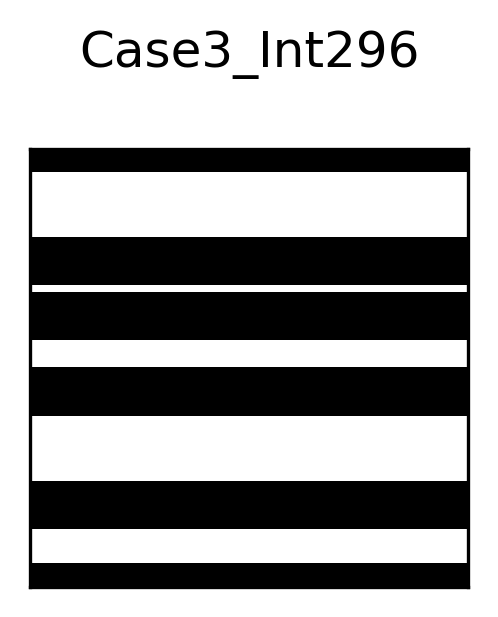

In [ ]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

img_shape = 128

fig = plt.figure(figsize=(15, 15), dpi =300)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.03, wspace=0.03)

#arr = np.array([141]) # partially laminated
arr = np.array([254]) # fully laminated
#arr = np.array([116]) # random
#arr = np.array([214]) # ellipse
#arr = np.array([196]) # rectangle

target_list = []
strain_cond = []
stress_cond = []

for i in arr:
  target_image = tx_test[i]
  #target_image = tx_train[i]
  ax = fig.add_subplot(10, 10, count + 1, xticks=[], yticks=[])
  ax.imshow(target_image.reshape((img_shape, img_shape)), cmap='gray')
  ax.set_title("{}".format(datalist[i//3]), fontsize=12)

  target_list.append((target_image - 0.5) / 0.5)

  strain_cond.append(ty_test[i, 0])
  stress_cond.append(ty_test[i, 1])
  #strain_cond.append(ty_train[i, 0])
  #stress_cond.append(ty_train[i, 1])
  count+=1

In [ ]:
import matplotlib.pyplot as plt
import math

strain_resl = np.arange(0.0, 1.2, 0.01)

likelihood_list= []
heat_list = []
log_prob_list = []
prob_list = []

prob_total = 0.

for i, img in enumerate(target_list):
        liklihood_list_temp = []
        prob_list_temp = []
        strain_target = strain_cond[i]
        stress_target = stress_cond[i]
        label_stress = np.full((1,1), stress_target).astype('float32')
        print('---------------------------------------------------')
        print('   target strain : {0:.3f} target stress : {1:.1f}         '.format(strain_target, stress_target))
        print('---------------------------------------------------')

        for st in strain_resl:
            label_strain = np.full((1,1), st).astype('float32')
            label = np.concatenate([label_strain, label_stress], 1)
            label = torch.from_numpy(label).clone()
            label = label.to("cuda")

            likelihood = inference(img.reshape(1, 1, img_shape, img_shape), label, model, prior, args)

            prob_list_temp.append(math.exp(likelihood.to('cpu').detach()))

            prob_total += math.exp(likelihood.to('cpu').detach())

            liklihood_list_temp.append(likelihood.to('cpu').detach())

            print('strain : {0:.2f} log likelihood : {1:.6f}'.format(st, likelihood.to('cpu').detach().numpy().copy()))


        likelihood_list.append(liklihood_list_temp)
        prob_list.append(prob_list_temp)

---------------------------------------------------
   target strain : 0.555 target stress : 0.6         
---------------------------------------------------
strain : 0.00 log likelihood : -0.323158
strain : 0.01 log likelihood : -0.313924
strain : 0.02 log likelihood : -0.305123
strain : 0.03 log likelihood : -0.296699
strain : 0.04 log likelihood : -0.288585
strain : 0.05 log likelihood : -0.280801
strain : 0.06 log likelihood : -0.273322
strain : 0.07 log likelihood : -0.266177
strain : 0.08 log likelihood : -0.259326
strain : 0.09 log likelihood : -0.252750
strain : 0.10 log likelihood : -0.246375
strain : 0.11 log likelihood : -0.240262
strain : 0.12 log likelihood : -0.234334
strain : 0.13 log likelihood : -0.228608
strain : 0.14 log likelihood : -0.223081
strain : 0.15 log likelihood : -0.217787
strain : 0.16 log likelihood : -0.212703
strain : 0.17 log likelihood : -0.207823
strain : 0.18 log likelihood : -0.203185
strain : 0.19 log likelihood : -0.198872
strain : 0.20 log like

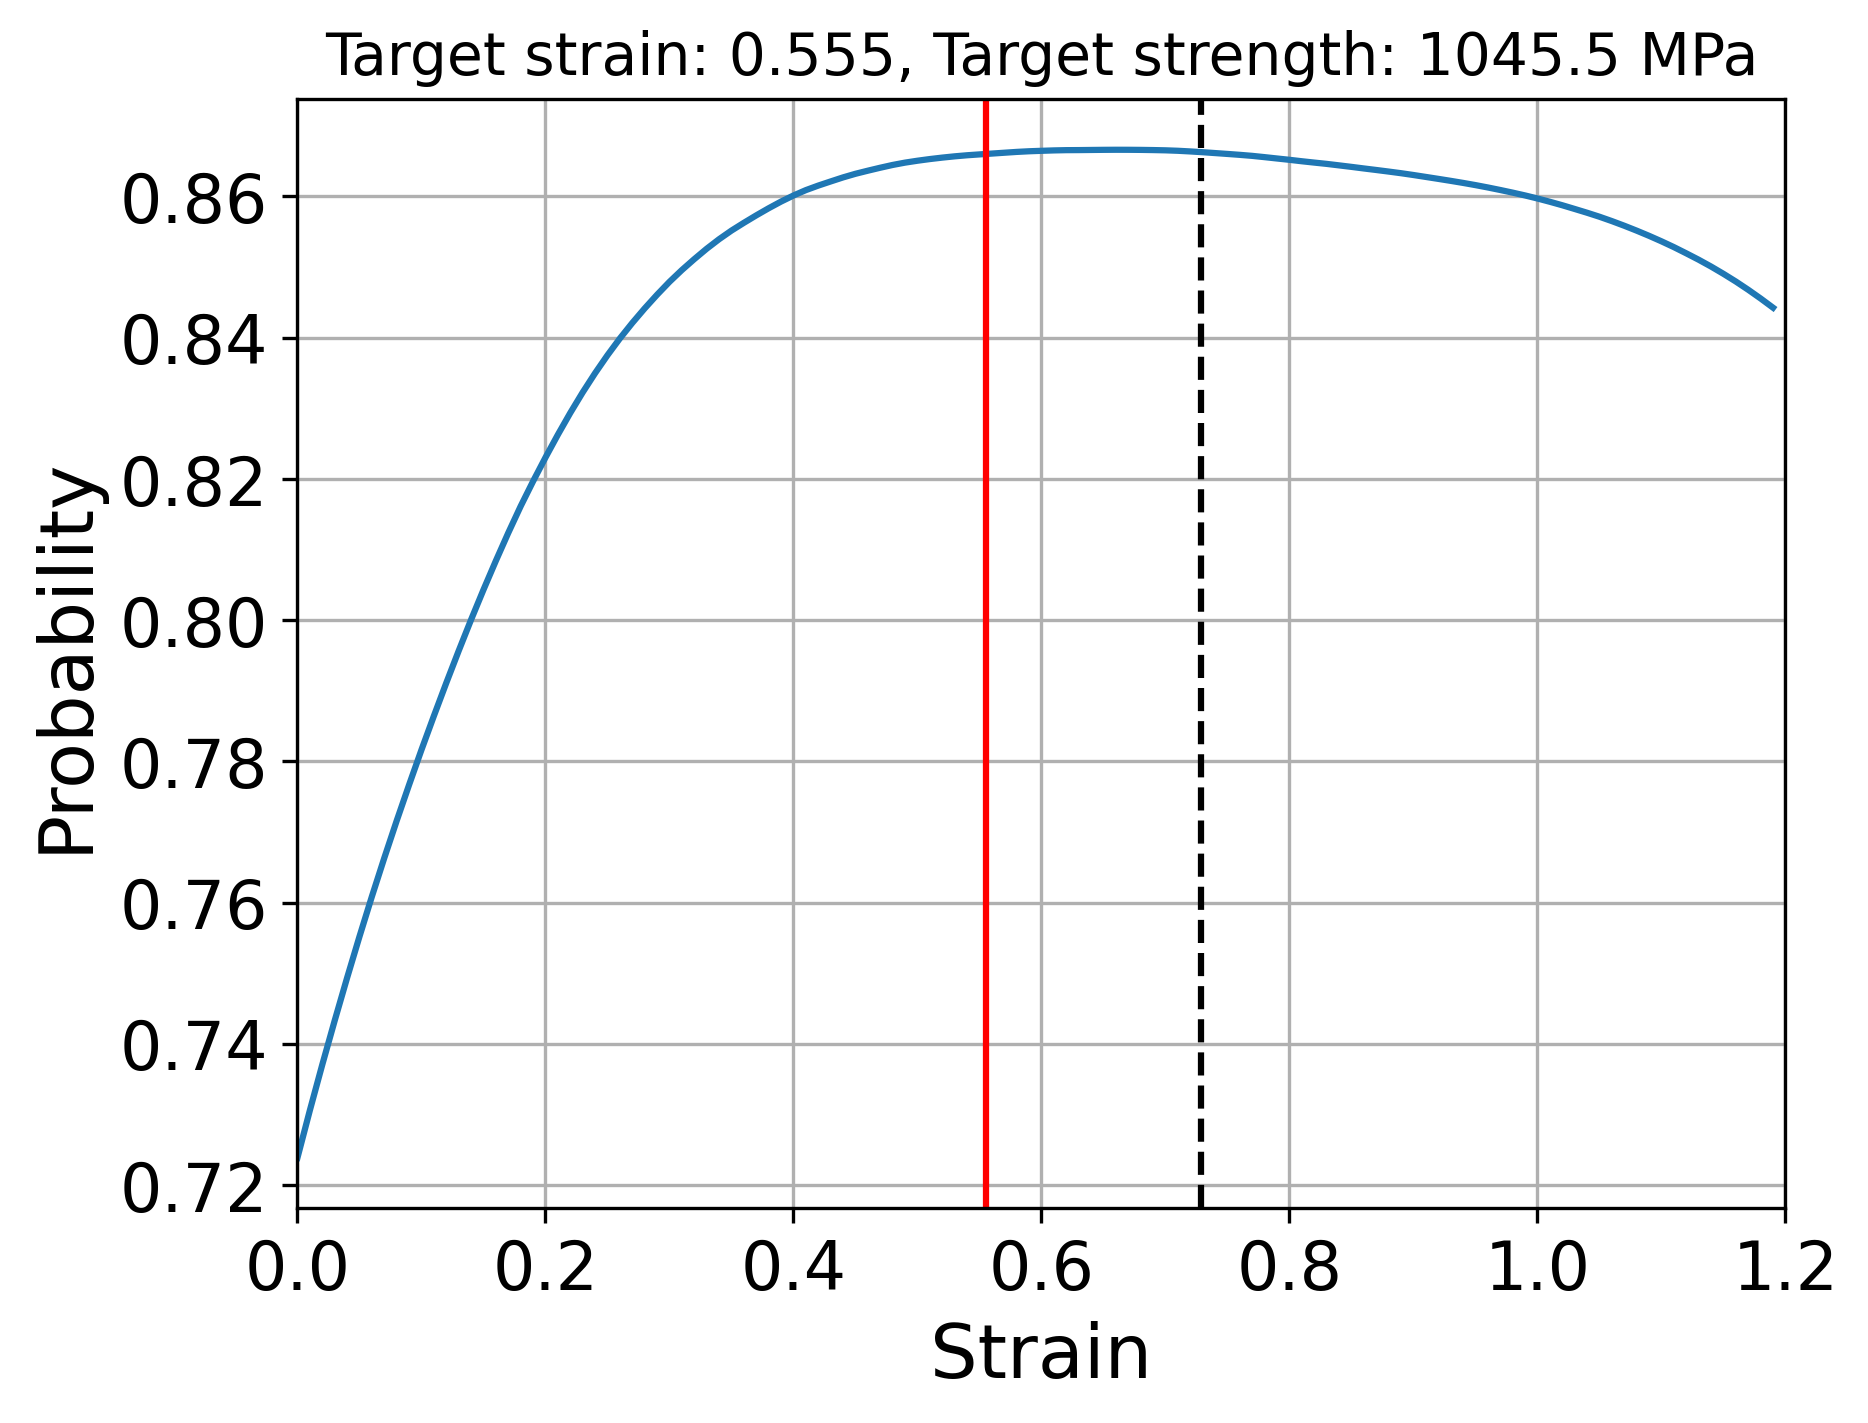

In [ ]:
fig, ax = plt.subplots(dpi=300)

for prob in prob_list:
    plt.plot(strain_resl, prob)

stress_target = (UTS_max - UTS_min)*stress_cond[0] + UTS_min

plt.grid()
plt.rcParams["font.size"] = 16
ax.set_xlabel("Strain", fontsize=18)
ax.set_ylabel("Probability", fontsize=18)
ax.set_title("Target strain: {0:.3f}, Target strength: {1:.1f} MPa".format(strain_target, stress_target), fontsize=14)
plt.xlim(0.0, 1.2)

plt.axvline(x=strain_cond[0], c="red")
plt.axvline(x=0.7286586, c="black", linestyle = "--")

plt.show()

### Bayseain Inference for Stress

In [ ]:
import matplotlib.pyplot as plt
import math

stress_resl = np.arange(0.0, 1500, 20)

likelihood_list= []
heat_list = []
log_prob_list = []
prob_list = []

prob_total = 0.

for i, img in enumerate(target_list):
        liklihood_list_temp = []
        prob_list_temp = []
        strain_target = strain_cond[i]
        stress_target = stress_cond[i]
        label_strain = np.full((1,1), strain_target).astype('float32')
        print('---------------------------------------------------')
        print('   target strain : {0:.3f} target stress : {1:.1f}         '.format(strain_target, stress_target))
        print('---------------------------------------------------')

        for st in stress_resl:
            label_stress = np.full((1,1), st).astype('float32')
            label_stress = regularization(label_stress, UTS_max, UTS_min)
            label = np.concatenate([label_strain, label_stress], 1)
            label = torch.from_numpy(label).clone()
            label = label.to("cuda")

            likelihood = inference(img.reshape(1, 1, img_shape, img_shape), label, model, prior, args)

            prob_list_temp.append(math.exp(likelihood.to('cpu').detach()))

            prob_total += math.exp(likelihood.to('cpu').detach())

            liklihood_list_temp.append(likelihood.to('cpu').detach())

            print('strain : {0:.2f} log likelihood : {1:.6f}'.format(st, likelihood.to('cpu').detach().numpy().copy()))


        likelihood_list.append(liklihood_list_temp)
        prob_list.append(prob_list_temp)

---------------------------------------------------
   target strain : 0.555 target stress : 0.6         
---------------------------------------------------
strain : 0.00 log likelihood : -5.533994
strain : 20.00 log likelihood : -5.366149
strain : 40.00 log likelihood : -5.188671
strain : 60.00 log likelihood : -5.002807
strain : 80.00 log likelihood : -4.805583
strain : 100.00 log likelihood : -4.596867
strain : 120.00 log likelihood : -4.377690
strain : 140.00 log likelihood : -4.144339
strain : 160.00 log likelihood : -3.899247
strain : 180.00 log likelihood : -3.644106
strain : 200.00 log likelihood : -3.380923
strain : 220.00 log likelihood : -3.107733
strain : 240.00 log likelihood : -2.824522
strain : 260.00 log likelihood : -2.537112
strain : 280.00 log likelihood : -2.258610
strain : 300.00 log likelihood : -1.995038
strain : 320.00 log likelihood : -1.750675
strain : 340.00 log likelihood : -1.527814
strain : 360.00 log likelihood : -1.323655
strain : 380.00 log likelihood 

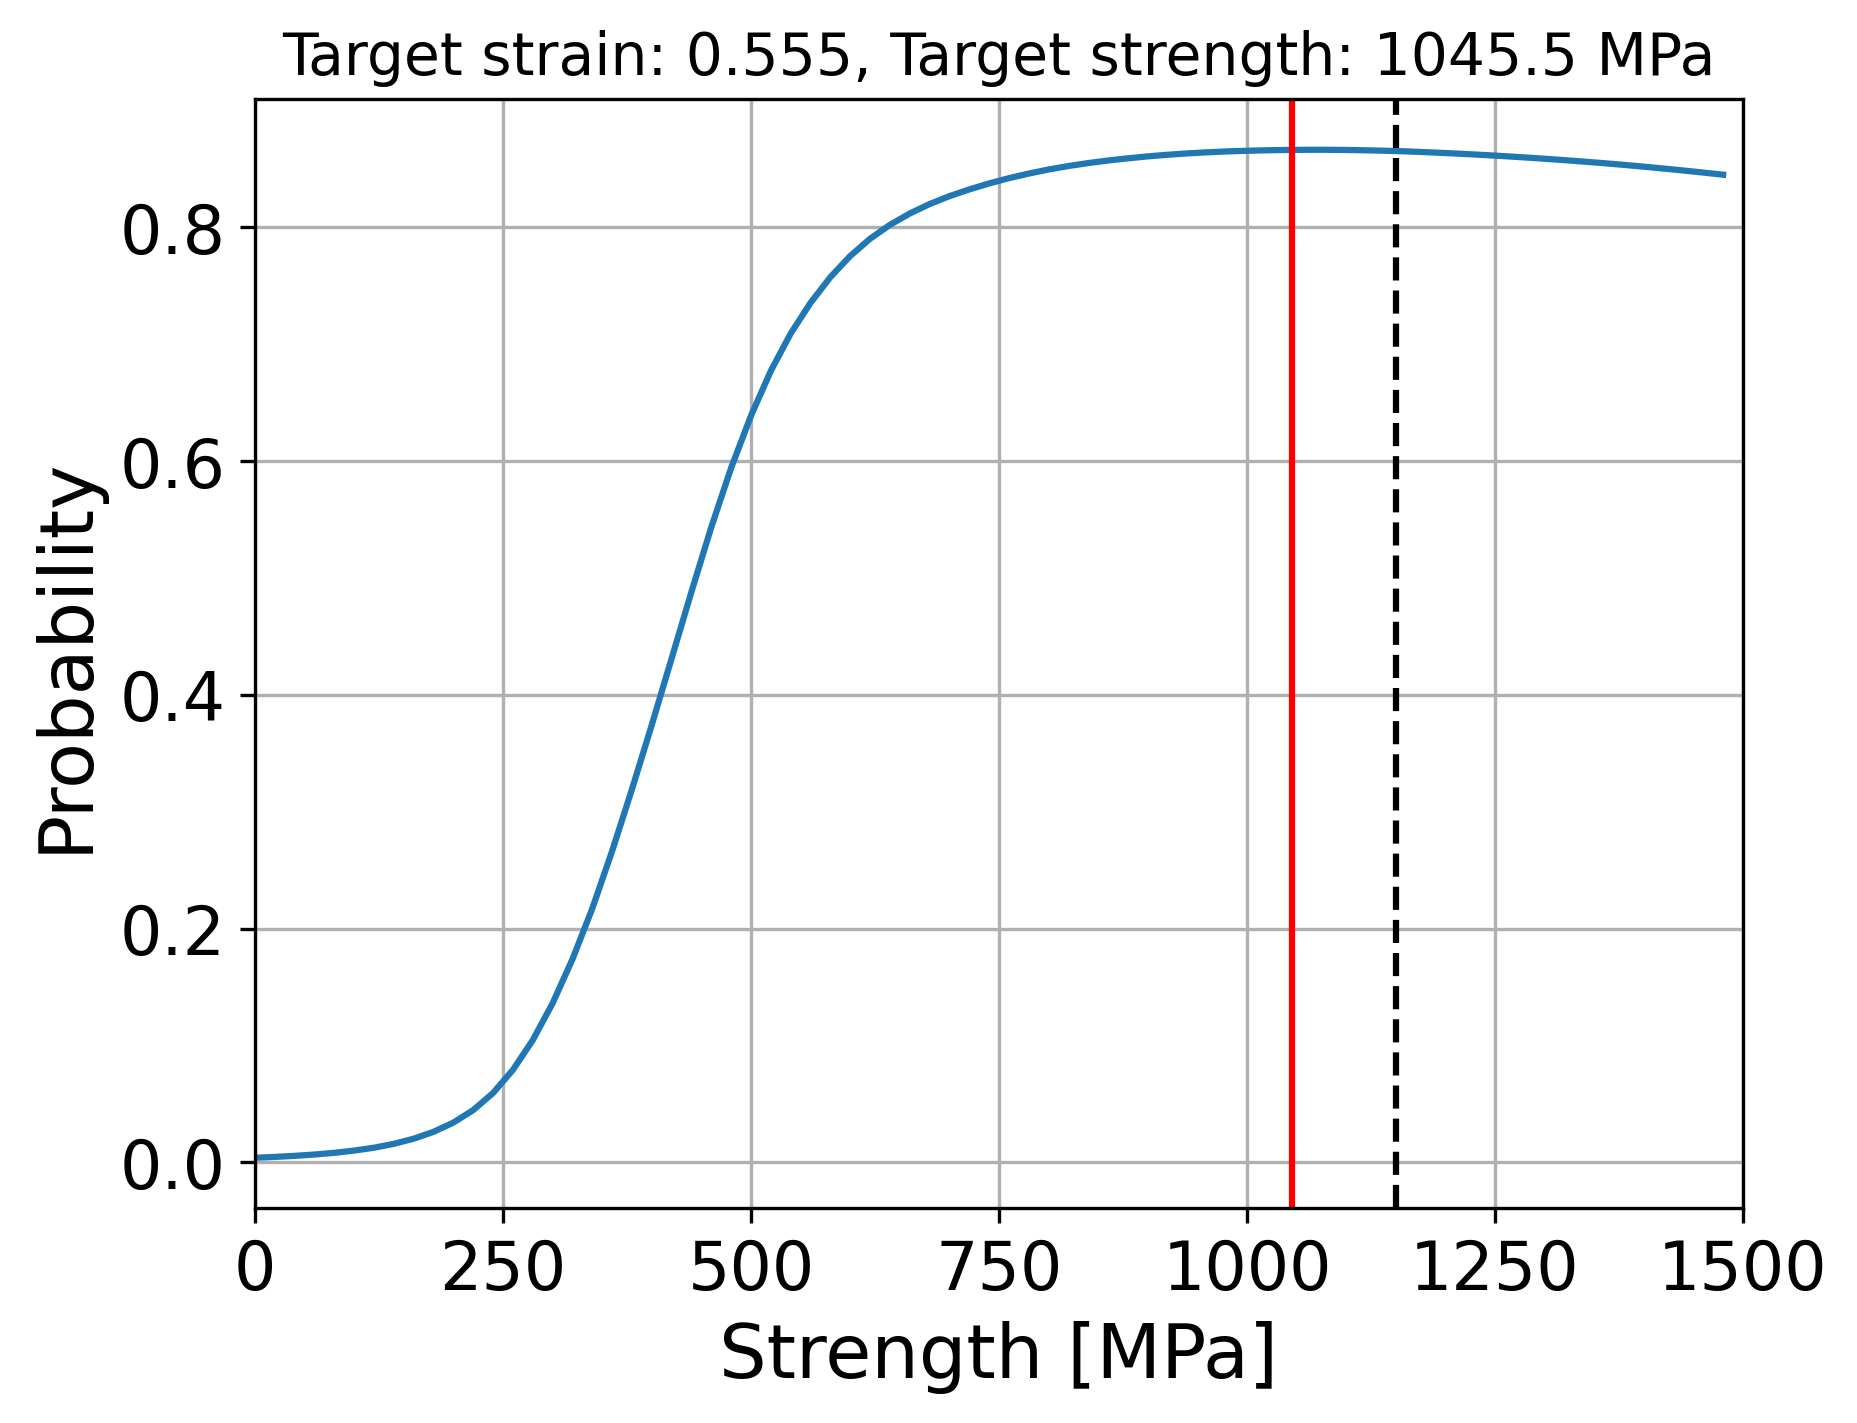

In [ ]:
fig, ax = plt.subplots(dpi=300)

for prob in prob_list:
    plt.plot(stress_resl, prob)

stress_target = (UTS_max - UTS_min)*stress_cond[0] + UTS_min

plt.grid()
plt.rcParams["font.size"] = 16
ax.set_xlabel("Strength [MPa]", fontsize=18)
ax.set_ylabel("Probability", fontsize=18)
ax.set_title("Target strain: {0:.3f}, Target strength: {1:.1f} MPa".format(strain_target, stress_target), fontsize=14)
plt.xlim(0.0, 1500.)

plt.axvline(x=stress_target, c="red")
plt.axvline(x=1150.377601479689, c="black", linestyle = "--")

plt.show()

### Point estimation by PixelCNN

In [ ]:
from tqdm.notebook import tqdm as tqdm

strain_resl = np.arange(0.0, 1.2, 0.01)

digits = 3 # 10^ -(digits - 1)

likelihood_list= []
heat_list = []
log_prob_list = []
prob_list = []
prediction_strain_list = []
prediction_stress_list = []
true_strain_list = []
true_stress_list = []
case_name = []

prob_total = 0.

for i, img in enumerate(tqdm(tx_test[:])):
        strain_resl_tmp = np.arange(0.0, 1.2, 0.1)
        stress_resl_tmp = np.arange(0.0, 1500, 100)
        strain_resl, stress_resl = np.meshgrid(strain_resl_tmp, stress_resl_tmp)

        img = (img.reshape(img_shape, img_shape) - 0.5) / 0.5

        strain_target = ty_test[i, 0]
        stress_target = ty_test[i, 1]

        for dig in range(digits + 1):
            liklihood_list_tmp = []
            prob_list_tmp = []

            order_strain = 10**(-(dig - 1) - 2)
            order_stress = 10**(-(dig - 1) + 1)

            if dig > 0:
                strain_resl_tmp = np.arange(max_strain_tmp - 5.*order_strain, max_strain_tmp + 5.*order_strain, order_strain)
                stress_resl_tmp = np.arange(max_stress_tmp - 5.*order_stress, max_stress_tmp + 5.*order_stress, order_stress)
                strain_resl, stress_resl = np.meshgrid(strain_resl_tmp, stress_resl_tmp)

            for j in range(len(strain_resl.reshape(-1))):
                strain_tmp = strain_resl.reshape(-1)[j]
                stress_tmp = stress_resl.reshape(-1)[j]

                label_strain = np.full((1,1), strain_tmp).astype('float32')
                label_stress = np.full((1,1), stress_tmp).astype('float32')
                label_stress = regularization(label_stress, UTS_max, UTS_min)

                label = np.concatenate([label_strain, label_stress], 1)
                label = torch.from_numpy(label).clone()
                label = label.to("cuda")

                likelihood = inference(img.reshape(1, 1, img_shape, img_shape), label, model, prior, args)

                prob_list_tmp.append(math.exp(likelihood.to('cpu').detach()))

                prob_total += math.exp(likelihood.to('cpu').detach())

                liklihood_list_tmp.append(likelihood.to('cpu').detach())

            max_tmp_ind = liklihood_list_tmp.index(max(liklihood_list_tmp))
            max_strain_tmp = strain_resl.reshape(-1)[max_tmp_ind]
            max_stress_tmp = stress_resl.reshape(-1)[max_tmp_ind]

        prediction_strain_list.append(max_strain_tmp)
        true_strain_list.append(strain_target)
        prediction_stress_list.append(max_stress_tmp)
        true_stress_list.append(stress_target * (UTS_max - UTS_min) + UTS_min)
        case_name.append(datalist[i//3])

        print("True strain : {0:.4f}  Predicted strain : {1:.4f}  True stress : {2:.4f}  Predicted stress : {3:.4f}  Index : {4}  Case name : {5}".format(strain_target, max_strain_tmp, stress_target * (UTS_max - UTS_min) + UTS_min, max_stress_tmp, i, datalist[i//3][:-1]))

  0%|          | 0/300 [00:00<?, ?it/s]

True strain : 0.1100  Predicted strain : 0.1479  True stress : 649.6744  Predicted stress : 685.1000  Index : 0  Case name : Case4_Int3392
True strain : 0.1100  Predicted strain : 0.1468  True stress : 649.6744  Predicted stress : 708.1000  Index : 1  Case name : Case4_Int3392
True strain : 0.1100  Predicted strain : 0.1277  True stress : 649.6744  Predicted stress : 697.1000  Index : 2  Case name : Case4_Int3392
True strain : 0.8500  Predicted strain : 0.8868  True stress : 481.3122  Predicted stress : 449.2000  Index : 3  Case name : Case4_Int2062
True strain : 0.8500  Predicted strain : 0.9579  True stress : 481.3122  Predicted stress : 497.4000  Index : 4  Case name : Case4_Int2062
True strain : 0.8500  Predicted strain : 0.8892  True stress : 481.3122  Predicted stress : 467.1000  Index : 5  Case name : Case4_Int2062
True strain : 0.2550  Predicted strain : 0.2455  True stress : 565.1589  Predicted stress : 527.4000  Index : 6  Case name : Case4_Int2673
True strain : 0.2550  Predi

In [ ]:
true_strain_np = np.array(true_strain_list)
prediction_strain_np = np.array(prediction_strain_list)

rsme = np.sqrt(np.mean((true_strain_np - prediction_strain_np) ** 2))

print("The loss of strain for validation dataset is {0:.3f}".format(rsme))

The loss of strain for validation dataset is 0.132


In [ ]:
from sklearn.metrics import r2_score

print(f"R-squared: {r2_score(true_strain_list, prediction_strain_list)}")

In [ ]:
true_stress_np = np.array(true_stress_list)
prediction_stress_np = np.array(prediction_stress_list)

rsme = np.sqrt(np.mean((true_stress_np - prediction_stress_np) ** 2))

print("The loss of stress for validation dataset is {0:.3f}".format(rsme))

The loss of stress for validation dataset is 63.583


In [ ]:
from sklearn.metrics import r2_score

print(f"R-squared: {r2_score(true_stress_list, prediction_stress_list)}")

In [ ]:
label = []
color = []

for i, c in enumerate(case_name):
  name = c[:5]
  if name == "Case1":
    label.append("Random")
    color.append("Blue")
  elif name == "Case2":
    label.append("Ellipse")
    color.append("Green")
  elif name == "Case3":
    label.append("Laminated")
    color.append("Red")
  elif name == "Case4" or name == "Case5":
    label.append("Rectangle")
    color.append("Black")

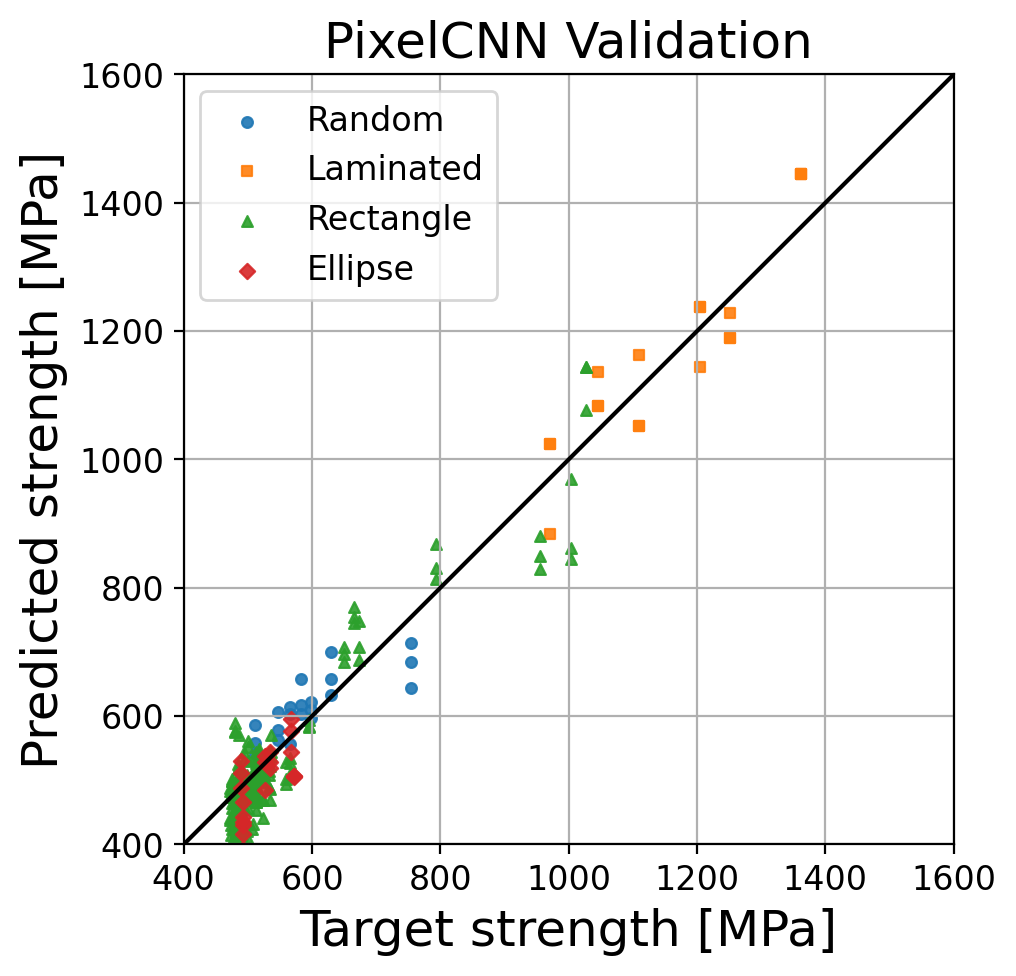

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 5), dpi=200)
ax = fig.add_subplot(111)
ax.set_aspect('equal')

unique_labels = ["Random", "Laminated", "Rectangle", "Ellipse"]
markers = ['o', 's', '^', 'D']

for i, lbl in enumerate(unique_labels):
    indices = [j for j, l in enumerate(label) if l == lbl]
    ax.scatter(true_stress_np[indices], prediction_stress_np[indices], alpha=0.9, s=15, linewidths=0.8, label=lbl, marker=markers[i])

plt.rcParams["font.size"] = 12

plt.title("PixelCNN Validation", fontsize=18)
plt.xlabel("Target strength [MPa]", fontsize=18)
plt.ylabel("Predicted strength [MPa]", fontsize=18)
plt.grid(True)
plt.xlim(400, 1600)
plt.ylim(400, 1600)

ax.plot([400, 1600], [400, 1600], color='black')

ax.legend(bbox_to_anchor=(0, 1), loc='upper left')

plt.show()


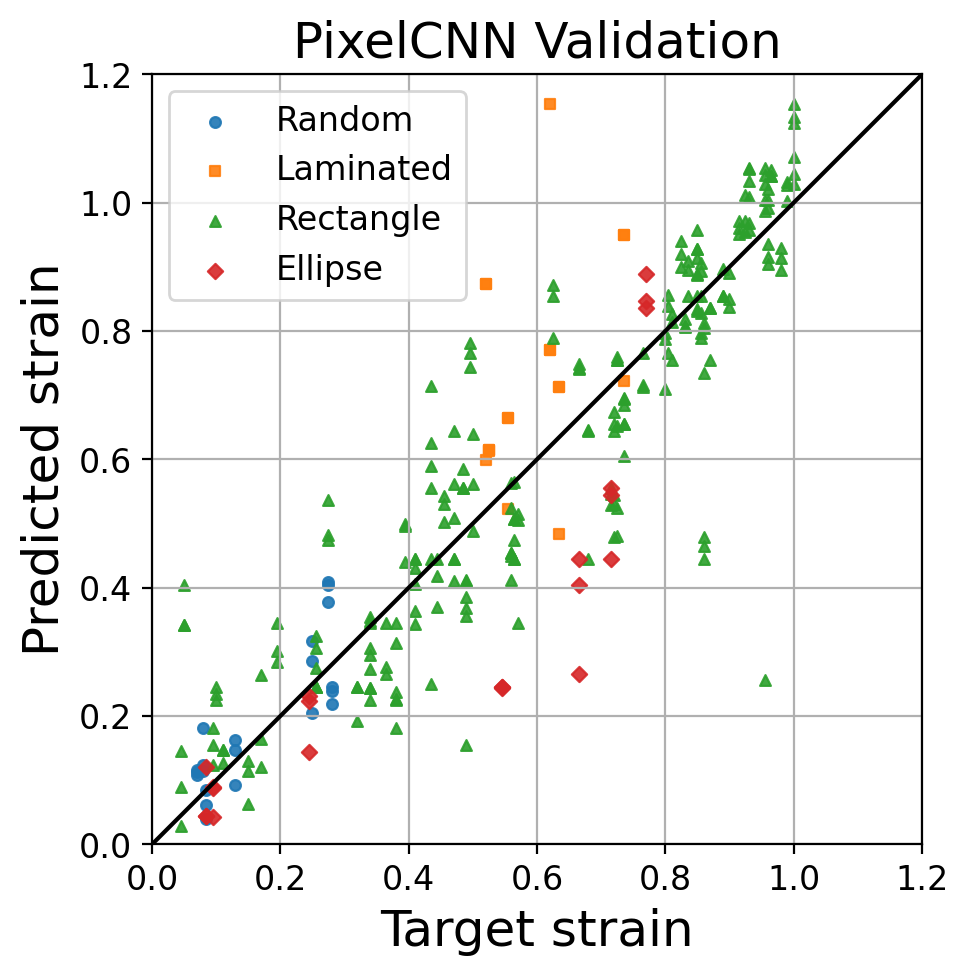

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 5), dpi=200)
ax = fig.add_subplot(111)
ax.set_aspect('equal')

unique_labels = ["Random", "Laminated", "Rectangle", "Ellipse"]
markers = ['o', 's', '^', 'D']

for i, lbl in enumerate(unique_labels):
    indices = [j for j, l in enumerate(label) if l == lbl]
    ax.scatter(true_strain_np[indices], prediction_strain_np[indices], alpha=0.9, s=15, linewidths=0.8, label=lbl, marker=markers[i])

plt.rcParams["font.size"] = 12
plt.title("PixelCNN Validation", fontsize=18)
plt.xlabel("Target strain", fontsize=18)
plt.ylabel("Predicted strain", fontsize=18)
plt.grid(True)
plt.xlim(0.0, 1.2)
plt.ylim(0.0, 1.2)

ax.plot([0.0, 0.2, 0.4, 0.6, 0.8, 1.2], [0.0, 0.2, 0.4, 0.6, 0.8, 1.2], color='black')

ax.legend(bbox_to_anchor=(0, 1), loc='upper left')

plt.show()


### Conventional CNN

In [ ]:
feature_shape = 128

#@title
class RegressionNet(torch.nn.Module):

    def __init__(self):
        super(RegressionNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv2 = torch.nn.Conv2d(16, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        #self.dropout1 = torch.nn.Dropout2d(p=0.3)
        self.normal1 = torch.nn.BatchNorm2d(16)

        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv4 = torch.nn.Conv2d(32, 32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        #self.dropout2 = torch.nn.Dropout2d(p=0.3)
        self.normal2 = torch.nn.BatchNorm2d(32)

        self.conv5 = torch.nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv6 = torch.nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        #self.dropout3 = torch.nn.Dropout2d(p=0.3)
        self.normal3 = torch.nn.BatchNorm2d(64)

        self.conv7 = torch.nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv8 = torch.nn.Conv2d(128, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        #self.dropout4 = torch.nn.Dropout2d(p=0.3)
        self.normal4 = torch.nn.BatchNorm2d(128)

        self.conv9 = torch.nn.Conv2d(128, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv10 = torch.nn.Conv2d(128, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool5 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        #self.dropout5 = torch.nn.Dropout2d(p=0.3)
        self.normal5 = torch.nn.BatchNorm2d(128)

        self.fc1 = torch.nn.Linear(128 * feature_shape//32 * feature_shape//32, 512)
        self.fc2 = torch.nn.Linear(512, 128)
        self.fc3 = torch.nn.Linear(128, 2)


    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.pool1(x)
        #x = self.dropout1(x)
        x = self.normal1(x)

        x = torch.nn.functional.relu(self.conv3(x))
        x = torch.nn.functional.relu(self.conv4(x))
        x = self.pool2(x)
        #x = self.dropout2(x)
        x = self.normal2(x)

        x = torch.nn.functional.relu(self.conv5(x))
        x = torch.nn.functional.relu(self.conv6(x))
        x = self.pool3(x)
        #x = self.dropout3(x)
        x = self.normal3(x)

        x = torch.nn.functional.relu(self.conv7(x))
        x = torch.nn.functional.relu(self.conv8(x))
        x = self.pool4(x)
        #x = self.dropout4(x)
        x = self.normal4(x)

        x = torch.nn.functional.relu(self.conv9(x))
        x = torch.nn.functional.relu(self.conv10(x))
        x = self.pool5(x)
        #x = self.dropout5(x)
        x = self.normal5(x)

        x = x.view(-1, 128 * feature_shape//32 * feature_shape//32)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)

        return x

net = RegressionNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = xm.xla_device()
print(device)

net = net.to(device)
summary(net, (1,feature_shape,feature_shape))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
            Conv2d-2         [-1, 16, 128, 128]           2,320
         MaxPool2d-3           [-1, 16, 64, 64]               0
       BatchNorm2d-4           [-1, 16, 64, 64]              32
            Conv2d-5           [-1, 32, 64, 64]           4,640
            Conv2d-6           [-1, 32, 64, 64]           9,248
         MaxPool2d-7           [-1, 32, 32, 32]               0
       BatchNorm2d-8           [-1, 32, 32, 32]              64
            Conv2d-9           [-1, 64, 32, 32]          18,496
           Conv2d-10           [-1, 64, 32, 32]          36,928
        MaxPool2d-11           [-1, 64, 16, 16]               0
      BatchNorm2d-12           [-1, 64, 16, 16]             128
           Conv2d-13          [-1, 128, 16, 16]          73,856
           Conv2d-14          [-

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.000001)
criterion = torch.nn.MSELoss()

In [ ]:
import os

train_loss = []
valid_loss = []
best_loss2 = -1.
save_filename = '/content/models/CNN/cnn.pt'

epochs = 50

if not os.path.exists('./models/CNN'):
    os.makedirs('./models/CNN')

# Define the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=128, shuffle=False, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=64, shuffle=False, drop_last=True, pin_memory=True)

for epoch in range(epochs):
  # Training
  net.train()
  count = 0
  running_train_loss = 0.0
  with torch.set_grad_enabled(True):
    for data in train_loader:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      running_train_loss += loss.item()
      loss.backward()
      optimizer.step()
      print("\r{0}, {1}/".format(loss, count+1), len(train_loader), end="")
      count+=1


  train_loss.append(running_train_loss / len(train_dataset))

  # Evaluation
  net.eval()
  running_valid_loss = 0.0
  with torch.set_grad_enabled(False):
    for data in valid_loader:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      running_valid_loss += loss.item()

  valid_loss.append(running_valid_loss / len(valid_dataset))

  if (epoch == 0) or (loss < best_loss2):
       best_loss2 = loss
       with open(save_filename, 'wb') as f:
             torch.save(net.state_dict(), f)

  print("\t{0},  {1}".format(labels[0, 0], outputs[0, 0]))
  print('\t#epoch:{}\ttrain loss: {}\tvalid loss: {}'.format(epoch, running_train_loss/len(train_dataset), running_valid_loss/len(valid_dataset)))

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(train_loss, label='train')
ax.plot(valid_loss, label='valid')
fig.show()

In [ ]:
import matplotlib.pyplot as plt

valid_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=len(tx_test), shuffle=False, drop_last=True, pin_memory=True)

inputs, labels = next(iter(valid_loader))

inputs = inputs.to(device)
labels = labels.to(device)
outputs = net(inputs)

labels = labels.cpu().detach().numpy()
outputs = outputs.cpu().detach().numpy()

In [ ]:
label = []
color = []

for i in range(len(tx_test)):
  c = datalist[i//3]
  name = c[:5]
  if name == "Case1":
    label.append("Random")
    color.append("Blue")
  elif name == "Case2":
    label.append("Ellipse")
    color.append("Green")
  elif name == "Case3":
    label.append("Laminated")
    color.append("Red")
  elif name == "Case4" or name == "Case5":
    label.append("Rectangle")
    color.append("Black")

In [ ]:
from sklearn.metrics import r2_score
ind = 0
print(f"R-squared: {r2_score(list(labels[:, ind]), list(outputs[:, ind]))}")

R-squared: 0.6702536739321392


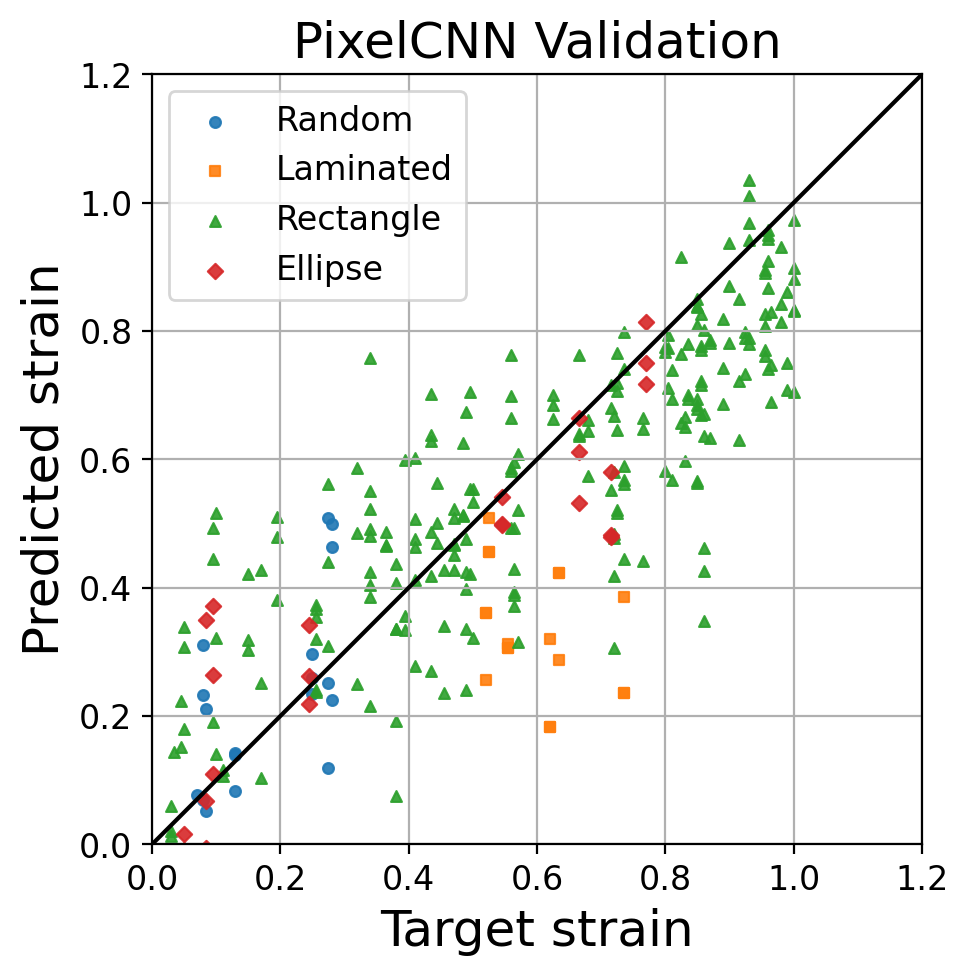

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 5), dpi=200)
ax = fig.add_subplot(111)
ax.set_aspect('equal')

unique_labels = ["Random", "Laminated", "Rectangle", "Ellipse"]
markers = ['o', 's', '^', 'D']

for i, lbl in enumerate(unique_labels):
    indices = [j for j, l in enumerate(label) if l == lbl]
    ax.scatter(labels[indices, ind], outputs[indices, ind], alpha=0.9, s=15, linewidths=0.8, label=lbl, marker=markers[i])

plt.rcParams["font.size"] = 12
plt.title("PixelCNN Validation", fontsize=18)
plt.xlabel("Target strain", fontsize=18)
plt.ylabel("Predicted strain", fontsize=18)
plt.grid(True)
plt.xlim(0.0, 1.2)
plt.ylim(0.0, 1.2)

ax.plot([0.0, 0.2, 0.4, 0.6, 0.8, 1.2], [0.0, 0.2, 0.4, 0.6, 0.8, 1.2], color='black')

ax.legend(bbox_to_anchor=(0, 1), loc='upper left')

plt.show()

In [ ]:
ind = 1
print(f"R-squared: {r2_score(list(labels[:, ind]), list(outputs[:, ind]))}")

R-squared: 0.7438313209259283


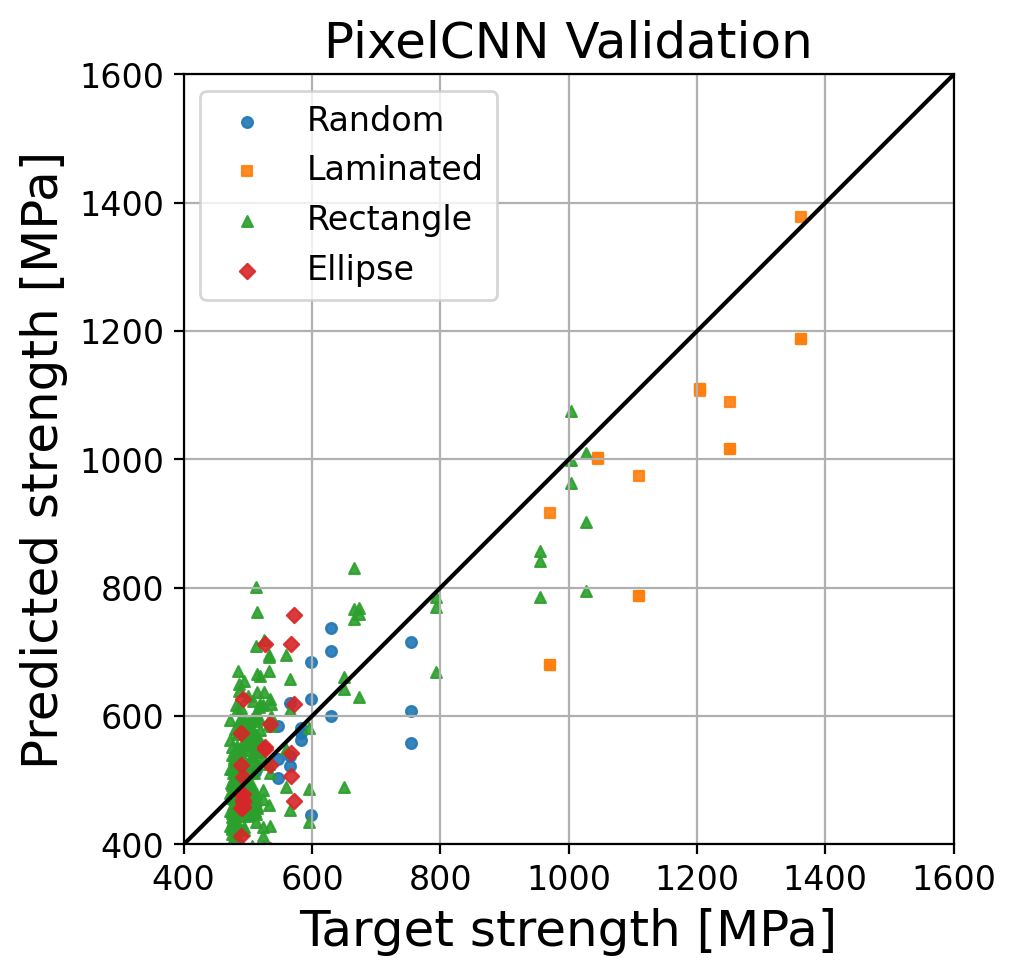

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 5), dpi=200)
ax = fig.add_subplot(111)
ax.set_aspect('equal')

unique_labels = ["Random", "Laminated", "Rectangle", "Ellipse"]
markers = ['o', 's', '^', 'D']

for i, lbl in enumerate(unique_labels):
    indices = [j for j, l in enumerate(label) if l == lbl]
    ax.scatter(labels[indices, ind] * (UTS_max - UTS_min) + UTS_min, outputs[indices, ind] * (UTS_max - UTS_min) + UTS_min, alpha=0.9, s=15, linewidths=0.8, label=lbl, marker=markers[i])

plt.rcParams["font.size"] = 12

plt.title("PixelCNN Validation", fontsize=18)
plt.xlabel("Target strength [MPa]", fontsize=18)
plt.ylabel("Predicted strength [MPa]", fontsize=18)
plt.grid(True)
plt.xlim(400, 1600)
plt.ylim(400, 1600)

ax.plot([400, 1600], [400, 1600], color='black')

ax.legend(bbox_to_anchor=(0, 1), loc='upper left')

plt.show()
